### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import PorterStemmer

###  Load the Dataset

In [2]:
data = pd.read_csv('Suicide_Detection.csv')
df = data.sample(n=10000, random_state=42)

### Showing first five sample of the dataset

In [3]:
df.head()

,Unnamed: 0,text,class
74414,111734,I Don't know?7? Months self harm free and the ...,suicide
149516,224358,I HAVE TO START BECOMING RICH I HAVE TO START ...,non-suicide
12484,18790,"A poem (haiku) for u/Me-Game-Dev hi, hello hel...",non-suicide
14043,21196,I've honestly got no idea what to do anymore.I...,suicide
30673,46089,Do you ever just cry? Like you just think abou...,non-suicide


### Preprocess the Dataset

In [4]:
df.drop(columns='Unnamed: 0', inplace=True)
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace(r'[^\w\s]+', '', regex=True)

In [30]:
# Download and apply stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

[nltk_data] Downloading package stopwords to C:\Users\Redmibook
[nltk_data]     13\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Tokenization and stemming
df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x))
ps = PorterStemmer()
df['text'] = df['text'].apply(lambda x: [ps.stem(i) for i in x])
df['text'] = df['text'].apply(lambda x: ' '.join(x))

### Handling Missing Values

In [7]:
# Remove any rows with missing values in 'text' column
df.dropna(subset=['text'], inplace=True)

In [8]:
# Remove any rows with missing values in 'text' column
df.dropna(subset=['text'], inplace=True)

In [9]:
# Verify there are no missing values left
print(df.isnull().sum())

text     0
class    0
dtype: int64


In [10]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(min_df=50, max_features=5000)
X = vectorizer.fit_transform(df['text']).toarray()

In [11]:
# Define the target variable
y = df['class']

### Split the data into training and testing sets

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=5)

# Check the shape of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (7000, 1320)
X_test shape: (3000, 1320)
y_train shape: (7000,)
y_test shape: (3000,)


### Visualize Class distribution

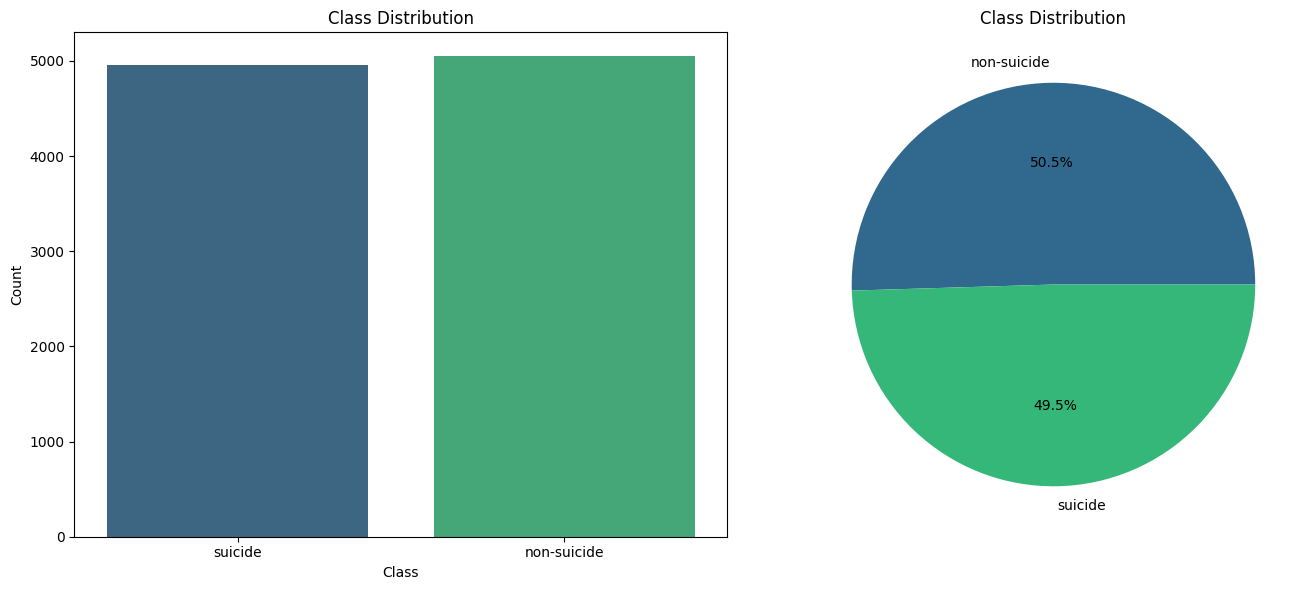

In [15]:
class_counts = df['class'].value_counts()

plt.figure(figsize=(14, 6))

# Bar plot for class distribution
plt.subplot(1, 2, 1)
sns.countplot(x='class', data=df, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Pie chart for class distribution
plt.subplot(1, 2, 2)
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis', n_colors=2))
plt.title('Class Distribution')

plt.tight_layout()
plt.show()


### Applying SMOTE (Balance the Dataset)

In [16]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the distribution of classes after applying SMOTE
print("Class distribution before SMOTE:", y_train.value_counts())
print("Class distribution after SMote:", y_train_smote.value_counts())


Class distribution before SMOTE: class
non-suicide    3524
suicide        3476
Name: count, dtype: int64
Class distribution after SMote: class
non-suicide    3524
suicide        3524
Name: count, dtype: int64


### Class distribution visualization after SMOTE

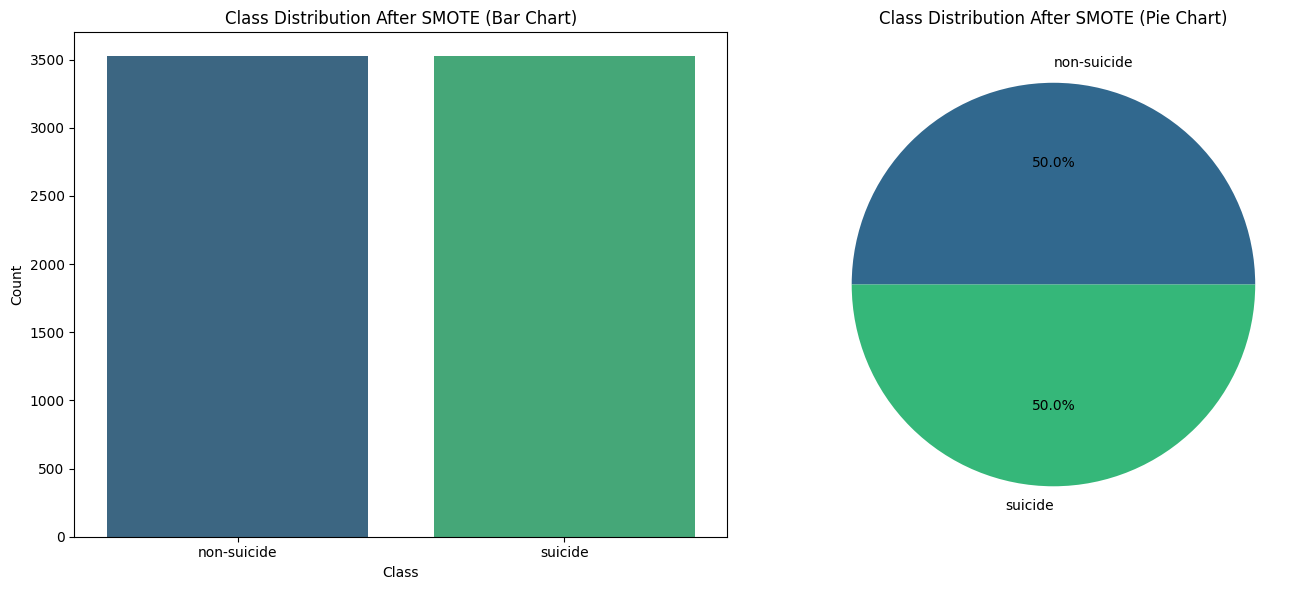

In [17]:
class_counts_smote = y_train_smote.value_counts()

plt.figure(figsize=(14, 6))

# Bar plot for class distribution after SMOTE
plt.subplot(1, 2, 1)
sns.countplot(x=y_train_smote, palette='viridis')
plt.title('Class Distribution After SMOTE (Bar Chart)')
plt.xlabel('Class')
plt.ylabel('Count')

# Pie chart for class distribution after SMOTE
plt.subplot(1, 2, 2)
plt.pie(class_counts_smote, labels=class_counts_smote.index, autopct='%1.1f%%', colors=sns.color_palette('viridis', n_colors=2))
plt.title('Class Distribution After SMOTE (Pie Chart)')

plt.tight_layout()
plt.show()


# Model Apply

XGB

In [21]:
from xgboost import XGBClassifier

model = XGBClassifier(eval_metric='map', max_depth=6, n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train.replace({"non-suicide":0, 'suicide':1}))

print('Training score:', model.score(X_train, y_train.replace({"non-suicide":0, 'suicide':1})))
print('Testing score:', model.score(X_test, y_test.replace({"non-suicide":0, 'suicide':1})))


Training score: 0.937
Testing score: 0.891


In [24]:
y_pred = model.predict(X_test)
# Print classification report
print(classification_report(y_test.replace({"non-suicide": 0, 'suicide': 1}), y_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      1524
           1       0.90      0.87      0.89      1476

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



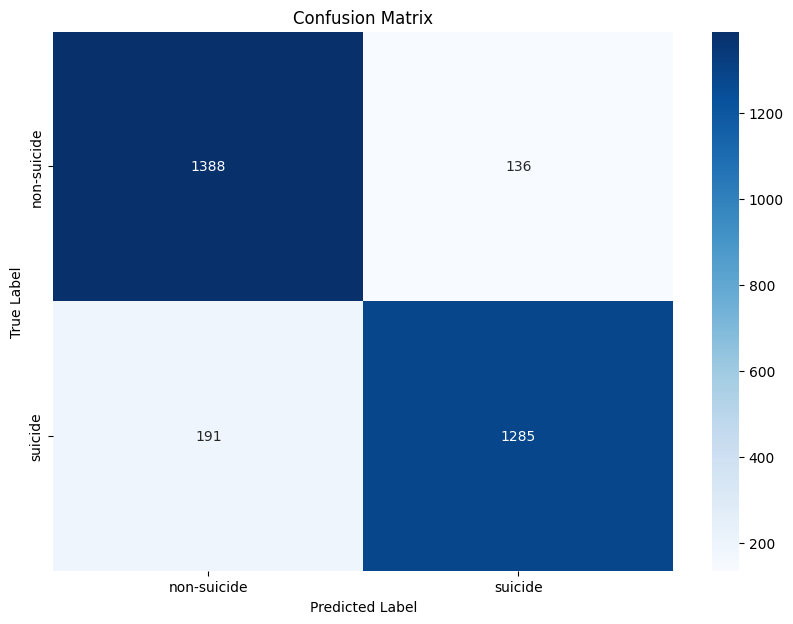

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


SVM

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# SVM Classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)
svm_pred = svm_classifier.predict(X_test)

# Evaluate the SVM Classifier
print("\nSVM Classifier:")
print("Accuracy:", accuracy_score(y_test, svm_pred))
print("Classification Report:")
print(classification_report(y_test, svm_pred))



SVM Classifier:
Accuracy: 0.9086666666666666
Classification Report:
              precision    recall  f1-score   support

 non-suicide       0.90      0.92      0.91      1524
     suicide       0.92      0.89      0.91      1476

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



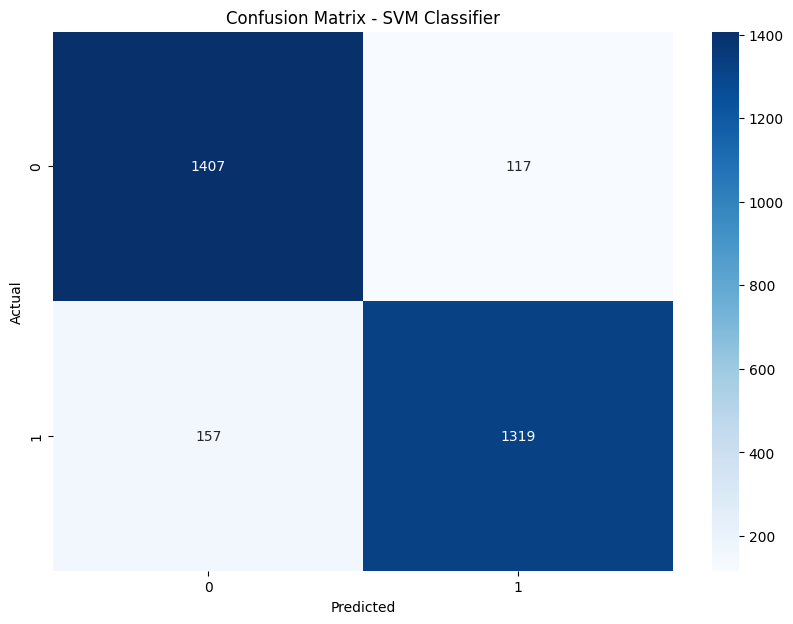

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix for SVM Classifier
svm_cm = confusion_matrix(y_test, svm_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Random Forest 

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
rf_pred = rf_classifier.predict(X_test)

# Evaluate the Random Forest Classifier
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Classification Report:")
print(classification_report(y_test, rf_pred))


Random Forest Classifier:
Accuracy: 0.8766666666666667
Classification Report:
              precision    recall  f1-score   support

 non-suicide       0.88      0.88      0.88      1524
     suicide       0.87      0.88      0.87      1476

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



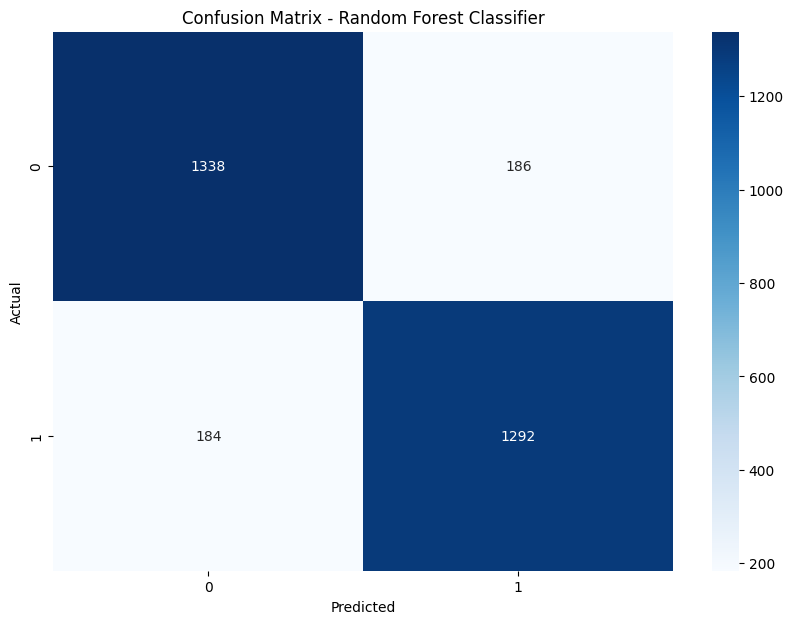

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix for Random Forest Classifier
rf_cm = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [95]:
import pickle

# Assuming svm_classifier is your trained SVM model
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_classifier, f)


In [96]:
def preprocess(inp):
    inp = inp.lower() # Convert to lower case 
    inp = inp.replace(r'[^\w\s]+', '') # Remove punctuations
    inp = [word for word in inp.split() if word not in stop_words] # Tokenize the sentence
    inp = ' '.join([ps.stem(i) for i in inp]) # Stemming
    inputToModel = vectorizer.transform([inp]).toarray() # Transform to vector form
    return inputToModel

In [97]:
def app(input_text):
    # Define the input text box
    print('Input : ', input_text) # Take input from user
    processed_array = preprocess(input_text) # Preprocess the text 
    predict = svm_classifier.predict(processed_array) # Model prediction using SVM classifier
    print('Output : ', predict[0])

In [100]:
app('I want to cry , I do not love my life anymore')

Input :  I want to cry , I do not love my life anymore
Output :  suicide


In [101]:
app('The weather is very nice.')

Input :  The weather is very nice.
Output :  non-suicide
